  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

        RETFound-MEH:DR Grade:0.8809	No/Mild vs rest:0.7132	AnyDR:0.6449
Total time: 1.4246s / mean time: 0.4749s


  0%|          | 0/3 [00:00<?, ?it/s]

          DERETFound:DR Grade:0.9027	No/Mild vs rest:0.6737	AnyDR:0.6973
Total time: 1.3262s / mean time: 0.4421s


  0%|          | 0/3 [00:00<?, ?it/s]

      RETFound-Green:DR Grade:0.9035	No/Mild vs rest:0.6705	AnyDR:0.7091
Total time: 0.4306s / mean time: 0.1435s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,No/Mild vs rest,AnyDR
RETFound-MEH,RETFound-MEH,0.8809,0.7132,0.6449,0.7099,0.7708,0.9302,0.9001
DERETFound,DERETFound,0.9027,0.6737,0.6973,0.7509,0.7484,0.9301,0.8948
RETFound-Green,RETFound-Green,0.9035,0.6705,0.7091,0.6503,0.8277,0.9090,0.8969


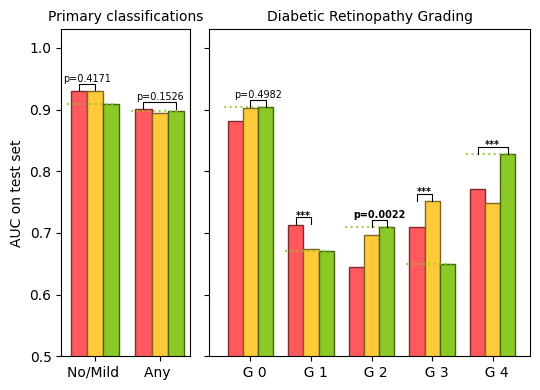

Statistically significant wins:  {'RETFound-MEH': 1, 'DERETFound': 1, 'RETFound-Green': 2}
Ties for first place:  {'RETFound-MEH': 2, 'DERETFound': 2, 'RETFound-Green': 2}


In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import joblib

# optional, for progress bars
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wilcoxon


def get_bootstrap_aucs(y_true, y_pred, bootstrap_iters=100):
    rng = np.random.RandomState(seed=42)
    idxs = list(range(y_pred.shape[0]))

    bootstrap_aucs = []
    for _ in range(bootstrap_iters):
        curr_idxs = rng.choice(idxs, size=len(idxs), replace=True)
        bootstrap_aucs.append(roc_auc_score(y_true[curr_idxs], y_pred[curr_idxs],
                                            multi_class='ovr', average='macro'))

    return np.median(bootstrap_aucs), bootstrap_aucs


def get_p_values(all_aucs):
    all_aucs = np.vstack(all_aucs)
    median_aucs = np.median(all_aucs, -1)
    second_best_idx, best_idx = median_aucs.argsort()[-2:]
    p_val = wilcoxon(all_aucs[best_idx], all_aucs[second_best_idx])[1]
    return p_val, (best_idx, second_best_idx)


def pval_to_str(p_val):
    if p_val < 0.0001:
        p_val = 'p<0.0001'
        p_val = '***'
    else:
        p_val = f'p={p_val:.4f}'
    return p_val


def darken_hex(hex_color, factor=0.5):
    # Ensure the factor is between 0 and 1
    factor = max(0, min(factor, 1))

    # Remove the hash symbol if present
    hex_color = hex_color.lstrip('#')

    # Convert hex to RGB
    rgb = tuple(int(hex_color[i:i + 2], 16) for i in (0, 2, 4))

    # Darken the RGB values by multiplying by the factor
    darkened_rgb = tuple(int(c * factor) for c in rgb)

    # Convert the RGB values back to hex
    darkened_hex = '#{:02x}{:02x}{:02x}'.format(*darkened_rgb)

    return darkened_hex


target_col = 'Retinopathy grade'
target_cols = list(range(5)) + [-1]

target_int_to_name = {_: f"Grade {_}" for _ in target_cols}
target_int_to_name[0] = 'Normal'
target_int_to_name[-1] = 'No/Mild'

dfbr = pd.read_csv('/mnt/c/Users/Justin/Desktop/labels.csv')
dfbr['Retinopathy grade'] = dfbr['DR_ICDR']
br_diab_mask = dfbr.diabetes=='yes'
# dfbr = dfbr[br_diab_mask].copy().reset_index()

dfidridtrain = pd.read_csv('/mnt/e/IDRiD_B_DiseaseGrading/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
dfidridtest = pd.read_csv('/mnt/e/IDRiD_B_DiseaseGrading/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')

name_X_list = [
    ('RETFound-MEH', 
     '/home/justin/RETFound_MAE/BRSET_RETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/IRID_Train_RETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/IRID_Test_RETFound_Feature_latent.npy'),
    ('DERETFound', 
     '/home/justin/RETFound_MAE/BRSET_DERETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/IRID_Train_DERETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/IRID_Test_DERETFound_Feature_latent.npy'),
    ('RETFound-Green', 
     'X_ours_brset.npy',
     'IRID_Train_X_ours.npy',
     'IRID_Test_X_ours.npy'),
]


models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green']
colors = ['#ff595e', '#ffca3a', '#8ac926']

def run_brset_to_idrid_exp(name_X_list,
                           models, colors, diab_only=False,
                           figsize=(5.5, 4), dashed_line_offsets=(-2.75, 0.25), xtick_loc_scaling=1, title_size='large'):
    targets = ['DR Grade', 'No/Mild vs rest', 'AnyDR', ]

    results_df = pd.DataFrame(columns=['Name'] + [f'DR Grade {_}' for _ in range(5)] 
                + ['No/Mild vs rest', 'AnyDR', ])

    name_bootstrap_aucs_dict = {}
    name_times_dict = {}
    for name, Xfname_br, Xfname_idrid_train, Xfname_idrid_test  in tqdm(name_X_list):
        np.random.seed(42)
        
        name_times_dict[name] = []
        median_aucs = []

        X_train = np.load(Xfname_br)
        X_test = np.load(Xfname_idrid_train)

        if diab_only:
            dfbr_curr = dfbr[dfbr['diabetes'].apply(lambda x: x=='yes').values].copy()
            X_train = X_train[dfbr['diabetes'].apply(lambda x: x=='yes').values]

        else:
            dfbr_curr = dfbr.copy()

        perf_str = f'{name:>20}:'
        for target_col in tqdm(targets, leave=True):

            if target_col.startswith('DR Grade'):
                y_train = dfbr_curr['Retinopathy grade'].values
                y_test = dfidridtrain['Retinopathy grade'].values

                start = time.time()
                clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train, y_train)
                preds = clf.predict_proba(X_test)
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                for grade in range(5):
                    curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test == grade, preds[:, grade])
                    name_bootstrap_aucs_dict[f'{name}-DR Grade {grade}'] = curr_bootstrap_aucs
                    median_aucs.append(curr_median_auc)

            elif target_col.startswith('No/Mild vs rest'):
                y_train = dfbr_curr['Retinopathy grade'].apply(lambda x: x > 1).values
                y_test = dfidridtrain['Retinopathy grade'].apply(lambda x: x > 1).values

                start = time.time()
                clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train, y_train)
                preds = clf.predict_proba(X_test)[:,1]
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test, preds)
                name_bootstrap_aucs_dict[f'{name}-{target_col}'] = curr_bootstrap_aucs
                median_aucs.append(curr_median_auc)
                
            elif target_col.startswith('AnyDR'):
                y_train = dfbr_curr['Retinopathy grade'].apply(lambda x: x > 0).values
                y_test = dfidridtrain['Retinopathy grade'].apply(lambda x: x > 0).values

                start = time.time()
                clf =make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train, y_train)
                preds = clf.predict_proba(X_test)[:,1]
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test, preds)
                name_bootstrap_aucs_dict[f'{name}-{target_col}'] = curr_bootstrap_aucs
                median_aucs.append(curr_median_auc)

            else:
                raise ValueError

        perf_str += '\t'.join([f'{c}:{v:.4f}' for c, v in zip(targets, median_aucs)])
        print(perf_str)
        print(f'Total time: {sum(name_times_dict[name]):.4f}s / mean time: {np.mean(name_times_dict[name]):.4f}s')

        results_df.loc[name] = [name] + median_aucs

    display(results_df.round(4))

    fig, axes = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [2, 5]})
    axes = axes.flat

    width = 0.25

    target_groups = {
        'Primary classifications': ['No/Mild vs rest', 'AnyDR'],
        'Diabetic Retinopathy Grading': [f'DR Grade {_}' for _ in range(5)],
    }
    wins = {_: 0 for _ in models}
    ties = {_: 0 for _ in models}

    for target_group, ax in zip(target_groups, axes):
        targets = target_groups[target_group]
        x = np.arange(len(targets))

        for i, model in enumerate(models):
            values = [results_df.loc[model, target] for target in targets]
            locs = x + i * width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] + dashed_line_offsets[0] * width
                    _right = locs[_idx] + dashed_line_offsets[1] * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [name_bootstrap_aucs_dict[f'{name}-{target}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()

            if p_val < 0.05:
                wins[models[best_idx]] += 1
            else:
                ties[models[best_idx]] += 1
                ties[models[second_best_idx]] += 1

            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val + 0.001, best_val + 0.012, best_val + 0.012, best_val + 0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val < 0.0001 else 0.01
            ax.text((start_loc + end_loc) / 2, best_val + text_loc_height_offset, pval_to_str(p_val), ha='center',
                    fontsize='x-small',
                    weight=None if not p_val < 0.05 else 'bold')

            ax.set_xticks(x + width * xtick_loc_scaling)
            targets_display = [_.replace('_', ' ').title() for _ in targets]
            targets_display = [_.replace('Dr', " ")
                               for _ in targets_display]
            targets_display = [_.replace('Anydr', "Any DR").replace('Vs Rest', 'DR')
                               for _ in targets_display]
            if title_size!='large':
                targets_display = [_.replace(' DR', " ").replace('Grade', 'G')
                                   for _ in targets_display]
            ax.set_xticklabels(targets_display, rotation=0, ha='center', fontsize='medium' if title_size=='large' else 10)
            ax.set_ylim(0.5, 1.03)
            ax.set_title(target_group, fontsize=title_size)

    axes[0].set_ylabel('AUC on test set')
    axes[1].set_yticklabels([])
    plt.tight_layout()
    plt.show()

    print('Statistically significant wins: ', wins)
    print('Ties for first place: ', ties)

run_brset_to_idrid_exp(name_X_list, models, colors, diab_only=True, title_size='medium')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

        RETFound-MEH:DR Grade:0.8893	No/Mild vs rest:0.7208	AnyDR:0.6470
Total time: 11.9787s / mean time: 3.9929s


  0%|          | 0/3 [00:00<?, ?it/s]

          DERETFound:DR Grade:0.8990	No/Mild vs rest:0.5157	AnyDR:0.7238
Total time: 11.0603s / mean time: 3.6868s


  0%|          | 0/3 [00:00<?, ?it/s]

      RETFound-Green:DR Grade:0.9282	No/Mild vs rest:0.6906	AnyDR:0.7326
Total time: 4.8784s / mean time: 1.6261s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,No/Mild vs rest,AnyDR
RETFound-MEH,RETFound-MEH,0.8893,0.7208,0.6470,0.7084,0.7889,0.9159,0.8962
DERETFound,DERETFound,0.8990,0.5157,0.7238,0.7398,0.7545,0.9492,0.9194
RETFound-Green,RETFound-Green,0.9282,0.6906,0.7326,0.6638,0.8445,0.9418,0.9198


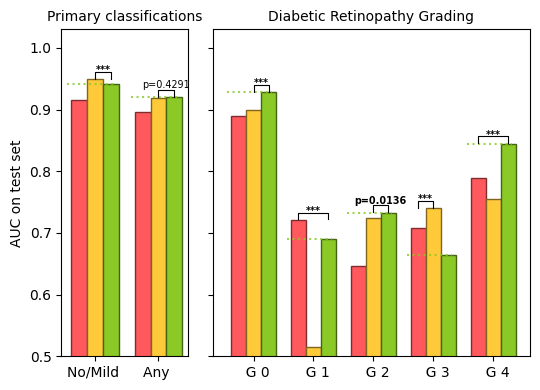

Statistically significant wins:  {'RETFound-MEH': 1, 'DERETFound': 2, 'RETFound-Green': 3}
Ties for first place:  {'RETFound-MEH': 0, 'DERETFound': 1, 'RETFound-Green': 1}


In [2]:
run_brset_to_idrid_exp(name_X_list, models, colors, diab_only=False, title_size='medium')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

        RETFound-MEH:DR Grade:0.6879	No/Mild vs rest:0.3894	AnyDR:0.6229
Total time: 0.4294s / mean time: 0.1431s


  0%|          | 0/3 [00:00<?, ?it/s]

          DERETFound:DR Grade:0.8253	No/Mild vs rest:0.4044	AnyDR:0.6041
Total time: 0.2908s / mean time: 0.0969s


  0%|          | 0/3 [00:00<?, ?it/s]

      RETFound-Green:DR Grade:0.7841	No/Mild vs rest:0.5138	AnyDR:0.6030
Total time: 0.1935s / mean time: 0.0645s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,No/Mild vs rest,AnyDR
RETFound-MEH,RETFound-MEH,0.6879,0.3894,0.6229,0.7132,0.7760,0.8027,0.7412
DERETFound,DERETFound,0.8253,0.4044,0.6041,0.7419,0.8462,0.8495,0.8147
RETFound-Green,RETFound-Green,0.7841,0.5138,0.6030,0.7838,0.6927,0.8644,0.7940


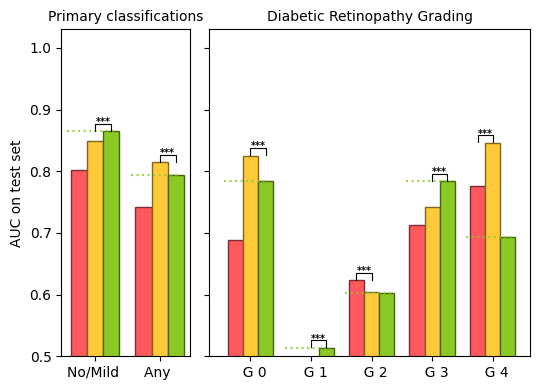

Statistically significant wins:  {'RETFound-MEH': 1, 'DERETFound': 3, 'RETFound-Green': 3}
Ties for first place:  {'RETFound-MEH': 0, 'DERETFound': 0, 'RETFound-Green': 0}


In [3]:
def run_idrid_to_brset_exp(name_X_list,
                           models, colors, diab_only=False,
                           figsize=(5.5, 4), dashed_line_offsets=(-2.75, 0.25), xtick_loc_scaling=1, title_size='large'):
    targets = ['DR Grade', 'No/Mild vs rest', 'AnyDR', ]

    results_df = pd.DataFrame(columns=['Name'] + [f'DR Grade {_}' for _ in range(5)] 
                + ['No/Mild vs rest', 'AnyDR', ])

    name_bootstrap_aucs_dict = {}
    name_times_dict = {}
    for name, Xfname_br, Xfname_idrid_train, Xfname_idrid_test  in tqdm(name_X_list):
        np.random.seed(42)
        
        name_times_dict[name] = []
        median_aucs = []

        X_train = np.load(Xfname_idrid_train)
        X_test = np.load(Xfname_br)

        if diab_only:
            dfbr_curr = dfbr[dfbr['diabetes'].apply(lambda x: x=='yes').values].copy()
            X_test = X_test[dfbr['diabetes'].apply(lambda x: x=='yes').values]
        else:
            dfbr_curr = dfbr.copy()

        perf_str = f'{name:>20}:'
        for target_col in tqdm(targets, leave=True):

            if target_col.startswith('DR Grade'):
                y_train = dfidridtrain['Retinopathy grade'].values
                y_test = dfbr_curr['Retinopathy grade'].values

                start = time.time()
                clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train, y_train)
                preds = clf.predict_proba(X_test)
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                for grade in range(5):
                    curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test == grade, preds[:, grade])
                    name_bootstrap_aucs_dict[f'{name}-DR Grade {grade}'] = curr_bootstrap_aucs
                    median_aucs.append(curr_median_auc)

            elif target_col.startswith('No/Mild vs rest'):
                y_train = dfidridtrain['Retinopathy grade'].apply(lambda x: x > 1).values
                y_test = dfbr_curr['Retinopathy grade'].apply(lambda x: x > 1).values

                start = time.time()
                clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train, y_train)
                preds = clf.predict_proba(X_test)[:,1]
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test, preds)
                name_bootstrap_aucs_dict[f'{name}-{target_col}'] = curr_bootstrap_aucs
                median_aucs.append(curr_median_auc)
                
            elif target_col.startswith('AnyDR'):
                y_train = dfidridtrain['Retinopathy grade'].apply(lambda x: x > 0).values
                y_test = dfbr_curr['Retinopathy grade'].apply(lambda x: x > 0).values

                start = time.time()
                clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train, y_train)
                preds = clf.predict_proba(X_test)[:,1]
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test, preds)
                name_bootstrap_aucs_dict[f'{name}-{target_col}'] = curr_bootstrap_aucs
                median_aucs.append(curr_median_auc)

            else:
                raise ValueError

        perf_str += '\t'.join([f'{c}:{v:.4f}' for c, v in zip(targets, median_aucs)])
        print(perf_str)
        print(f'Total time: {sum(name_times_dict[name]):.4f}s / mean time: {np.mean(name_times_dict[name]):.4f}s')

        results_df.loc[name] = [name] + median_aucs

    display(results_df.round(4))

    fig, axes = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [2, 5]})
    axes = axes.flat

    width = 0.25

    target_groups = {
        'Primary classifications': ['No/Mild vs rest', 'AnyDR'],
        'Diabetic Retinopathy Grading': [f'DR Grade {_}' for _ in range(5)],
    }
    wins = {_: 0 for _ in models}
    ties = {_: 0 for _ in models}

    for target_group, ax in zip(target_groups, axes):
        targets = target_groups[target_group]
        x = np.arange(len(targets))

        for i, model in enumerate(models):
            values = [results_df.loc[model, target] for target in targets]
            locs = x + i * width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] + dashed_line_offsets[0] * width
                    _right = locs[_idx] + dashed_line_offsets[1] * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [name_bootstrap_aucs_dict[f'{name}-{target}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()

            if p_val < 0.05:
                wins[models[best_idx]] += 1
            else:
                ties[models[best_idx]] += 1
                ties[models[second_best_idx]] += 1

            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val + 0.001, best_val + 0.012, best_val + 0.012, best_val + 0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val < 0.0001 else 0.01
            if best_val>0.5:
                ax.text((start_loc + end_loc) / 2, best_val + text_loc_height_offset, pval_to_str(p_val), ha='center',
                        fontsize='x-small',
                        weight=None if not p_val < 0.05 else 'bold')

            ax.set_xticks(x + width * xtick_loc_scaling)
            targets_display = [_.replace('_', ' ').title() for _ in targets]
            targets_display = [_.replace('Dr', " ")
                               for _ in targets_display]
            targets_display = [_.replace('Anydr', "Any DR").replace('Vs Rest', 'DR')
                               for _ in targets_display]
            if title_size!='large':
                targets_display = [_.replace(' DR', " ").replace('Grade', 'G')
                                   for _ in targets_display]
            ax.set_xticklabels(targets_display, rotation=0, ha='center', fontsize='medium' if title_size=='large' else 10)
            ax.set_ylim(0.5, 1.03)
            ax.set_title(target_group, fontsize=title_size)

    axes[0].set_ylabel('AUC on test set')
    axes[1].set_yticklabels([])
    plt.tight_layout()
    plt.show()

    print('Statistically significant wins: ', wins)
    print('Ties for first place: ', ties)

run_idrid_to_brset_exp(name_X_list, models, colors, diab_only=True, title_size='medium')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

        RETFound-MEH:DR Grade:0.7068	No/Mild vs rest:0.4017	AnyDR:0.6619
Total time: 0.6703s / mean time: 0.2234s


  0%|          | 0/3 [00:00<?, ?it/s]

          DERETFound:DR Grade:0.8652	No/Mild vs rest:0.4283	AnyDR:0.6702
Total time: 0.9949s / mean time: 0.3316s


  0%|          | 0/3 [00:00<?, ?it/s]

      RETFound-Green:DR Grade:0.8251	No/Mild vs rest:0.3965	AnyDR:0.5642
Total time: 0.6446s / mean time: 0.2149s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,No/Mild vs rest,AnyDR
RETFound-MEH,RETFound-MEH,0.7068,0.4017,0.6619,0.7832,0.7961,0.8347,0.7536
DERETFound,DERETFound,0.8652,0.4283,0.6702,0.8201,0.9042,0.8669,0.8530
RETFound-Green,RETFound-Green,0.8251,0.3965,0.5642,0.8434,0.7610,0.8887,0.8315


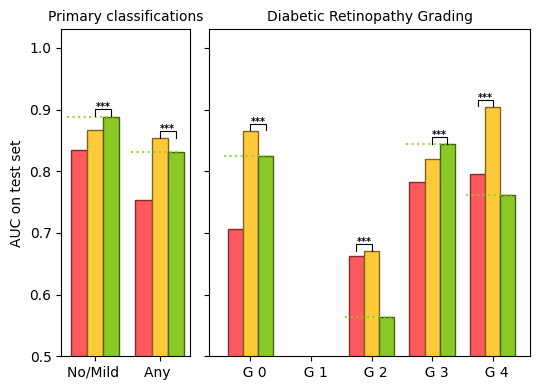

Statistically significant wins:  {'RETFound-MEH': 0, 'DERETFound': 5, 'RETFound-Green': 2}
Ties for first place:  {'RETFound-MEH': 0, 'DERETFound': 0, 'RETFound-Green': 0}


In [4]:
run_idrid_to_brset_exp(name_X_list, models, colors, diab_only=False, title_size='medium')